In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from pathlib import Path
path = Path('datasets\cta-ridership-daily-boarding-totals.csv')
df = pd.read_csv(path , parse_dates=['service_date'])
df.columns = ['date', 'day_type', 'bus', 'rail', 'total']
df = df.sort_values('date').set_index('date')
df = df.drop('total', axis = 1)
df = df.drop_duplicates()

In [3]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [4]:
df.describe()

,bus,rail
count,6.755000e+03,6.755000e+03
mean,7.990159e+05,5.726775e+05
std,2.313009e+05,1.788232e+05
min,1.241540e+05,8.799200e+04
25%,6.112195e+05,4.232585e+05
50%,8.761110e+05,6.203430e+05
75%,9.885210e+05,7.152315e+05
max,1.211992e+06,1.146516e+06


array([[<Axes: title={'center': 'bus'}>,
        <Axes: title={'center': 'rail'}>]], dtype=object)

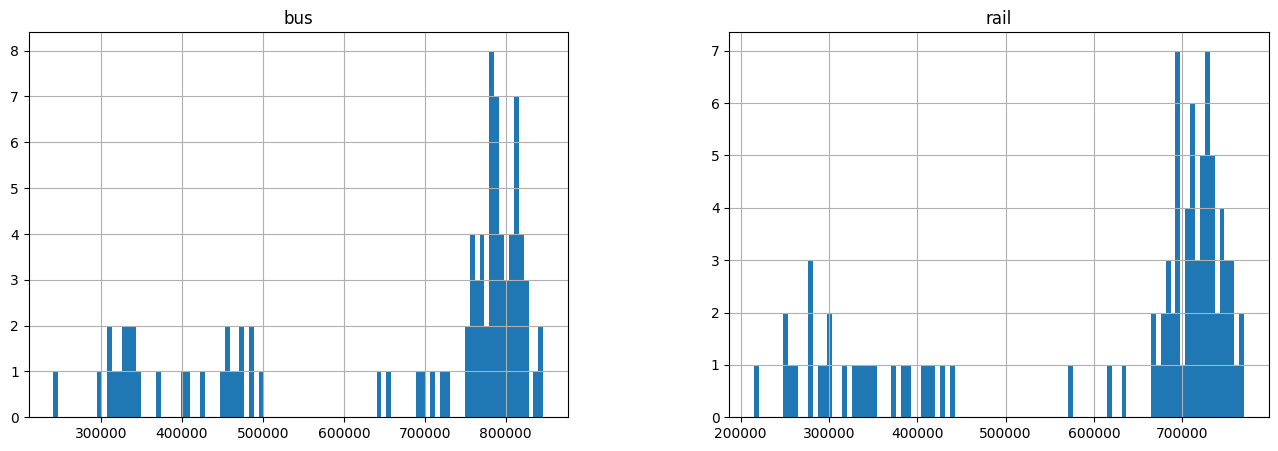

In [5]:
df['2019-03':'2019-05'].hist(bins = 100, figsize= (16,5))

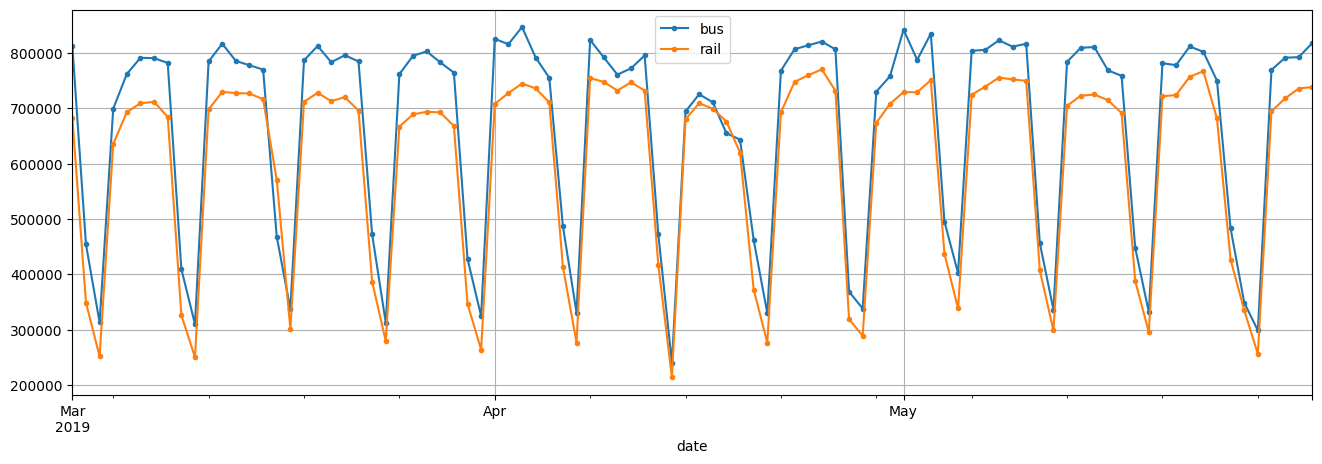

In [6]:
df['2019-03':'2019-05'].plot(grid = True, marker = '.', figsize = (16, 5))
plt.show()

In [7]:
diff_7 = df[['bus', 'rail']].diff(7)['2019-3':'2019-5']

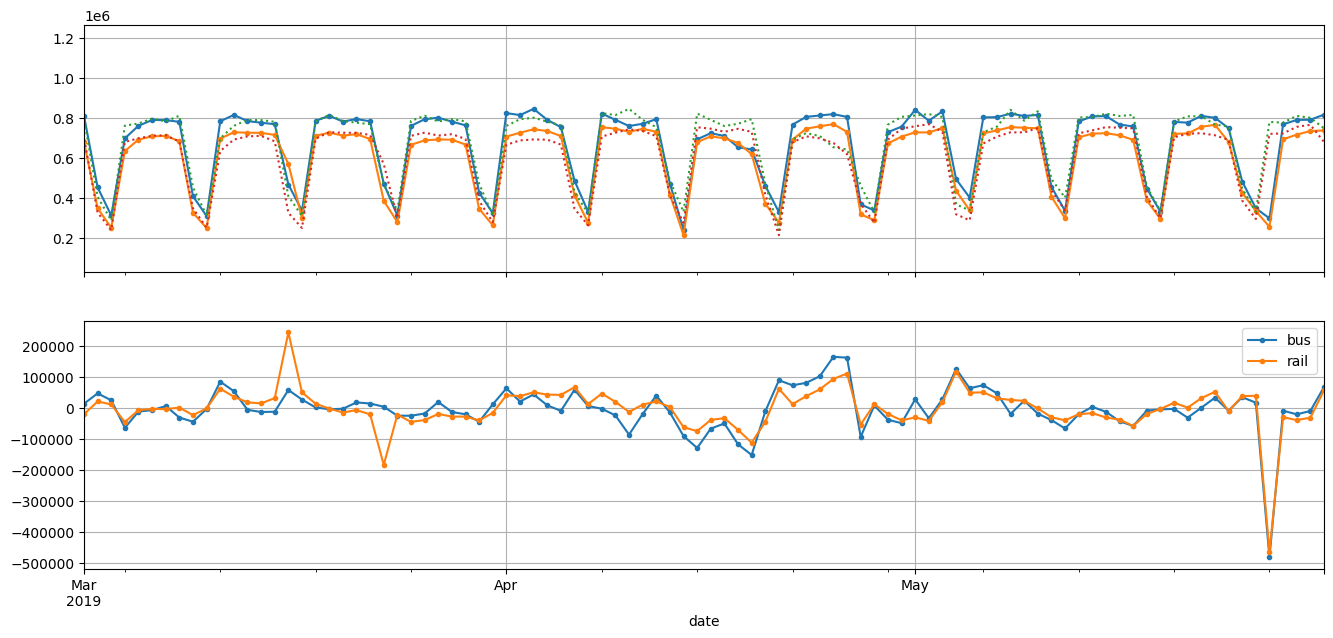

In [8]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (16,8))
df.plot(ax = axs[0], legend = False , marker = '.')
df.shift(7).plot(ax = axs[0], grid = True, legend = False, linestyle = ':')
diff_7.plot(ax = axs[1], grid = True, marker = '.')
plt.show()

In [9]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [10]:
targets = df[['bus', 'rail']]['2019-3': '2019-5']

In [11]:
(diff_7/targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

C:\Users\isthi\AppData\Local\Temp\ipykernel_21488\2778962719.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[['bus', 'rail']].resample('M').mean()


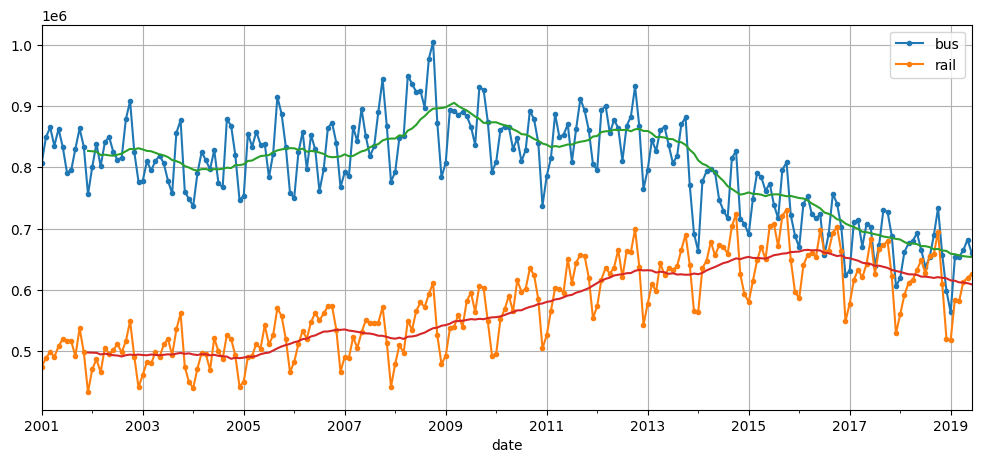

In [12]:
period = slice('2001', '2019')
df_monthly = df[['bus', 'rail']].resample('M').mean()
rolling_average_12_months = df_monthly[period].rolling(window = 12).mean()

fig , ax = plt.subplots(figsize=(12,5))
df_monthly[period].plot(ax = ax, marker = '.')
rolling_average_12_months.plot(ax = ax, grid = True , legend =False)
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
origin , today = '2019-01-01' , '2019-5-31'
rail_series = df.loc[origin:today]['rail'].asfreq('D')
model = ARIMA(rail_series, 
              order = (1,0,0),
              seasonal_order = (0,1,1,7))
model = model.fit()
y_pred = model.forecast()

In [15]:
y_pred

2019-06-01    427758.626286
Freq: D, dtype: float64

In [16]:
rail_train = df['rail']['2016 - 01':'2018-12']/ 1e6
rail_vail = df['rail']['2019-01':'2019-05']/ 1e6
rail_test = df['rail']['2019-01':'2019-05']/ 1e6

In [17]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets = rail_train[seq_length:],
    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed = 42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_vail.to_numpy(),
    targets = rail_vail[seq_length:],
    sequence_length = seq_length,
    batch_size = 32
)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences= True, input_shape = [None,1]),
    tf.keras.layers.SimpleRNN(32, return_sequences= True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

C:\Users\isthi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.Adam(beta_1 = 0.9),
              metrics = ['mae']
              )

In [20]:
history = model.fit(train_ds , validation_data= valid_ds , epochs = 500, callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mae',
                                                            patience = 50,
                                                            restore_best_weights = True)])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0293 - mae: 0.1863 - val_loss: 0.0055 - val_mae: 0.0848
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0065 - mae: 0.0828 - val_loss: 0.0021 - val_mae: 0.0391
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0042 - mae: 0.0587 - val_loss: 0.0022 - val_mae: 0.0418
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038 - mae: 0.0560 - val_loss: 0.0024 - val_mae: 0.0409
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0039 - mae: 0.0546 - val_loss: 0.0028 - val_mae: 0.0524
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0041 - mae: 0.0655 - val_loss: 0.0019 - val_mae: 0.0360
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - mae: 0.0501 - val_loss: 0.0020 - val_mae: 0.0357
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0036 - mae: 0.0526 - val_loss: 0.0021 - val_mae: 0.0425
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - lo

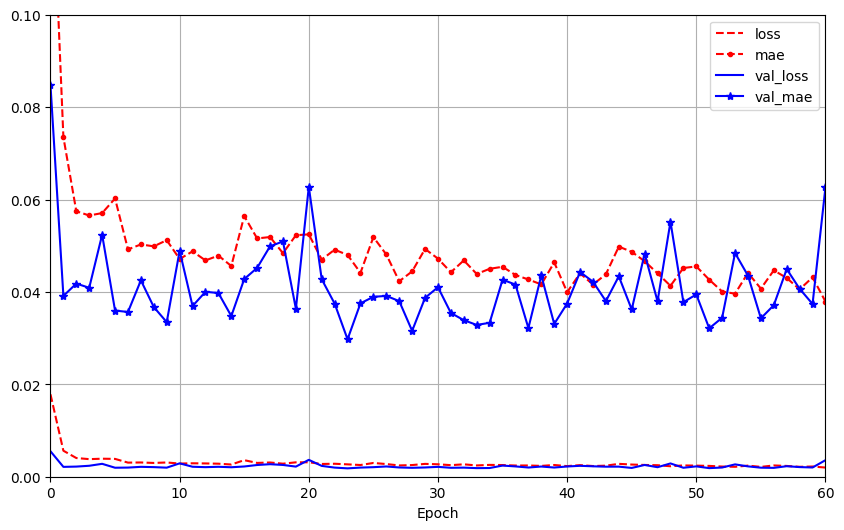

In [21]:
pd.DataFrame(history.history).plot(figsize = (10, 6), xlim = [0,60], ylim = [0,0.1], grid =True, xlabel = 'Epoch', style = ['r--', 'r--.', 'b-', 'b-*'])
plt.show()

In [22]:
model.evaluate(valid_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - mae: 0.0284


[0.0018107402138411999, 0.02975003607571125]

In [23]:
val_pred = model.predict(valid_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


## Predicting several timesteps ahead in sequences

In [24]:
df_multivar = df[['bus', 'rail']]/ 1e6
df_multivar['next_day_type'] = df['day_type'].shift(-1)
df_multivar = pd.get_dummies(df_multivar)

In [25]:
multivar_train  = df_multivar['2016-01': '2018-12']
multivar_valid = df_multivar['2019-01': '2019-05']
multivar_test = df_multivar['2019-06':]

In [26]:
def split_targets(multivar_series , targets_ahead = 14, target_col = 1):
    return multivar_series[:, :-targets_ahead] , multivar_series[: , -targets_ahead: , target_col]

In [27]:
train_multivar_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_train.to_numpy().astype(np.float32),
    targets = None,
    sequence_length = seq_length + 14,
    batch_size = 32,
    shuffle = True,
    seed  = 42
).map(split_targets)

In [28]:
valid_multivar_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_valid.to_numpy().astype(np.float32),
    targets = None,
    sequence_length = seq_length + 14,
    batch_size = 32
).map(split_targets)

In [29]:
TimeStepsForecast = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences= True, input_shape = [None,5]),
    tf.keras.layers.SimpleRNN(32, return_sequences= True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(14)
])

C:\Users\isthi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
TimeStepsForecast.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.Adam(beta_1 = 0.9),
              metrics = ['mae'])

In [31]:
for x, y in train_multivar_ds.take(1):
    print("Input shape:", x.shape)
    print("Target shape:", y.shape)


Input shape: (32, 56, 5)
Target shape: (32, 14)


In [32]:
historymulti_var = TimeStepsForecast.fit(train_multivar_ds , validation_data= valid_multivar_ds, epochs = 500,
                                         callbacks = [tf.keras.callbacks.EarlyStopping( monitor = 'val_mae',
                                                                                       patience = 50,
                                                                                       restore_best_weights = True)])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.1449 - mae: 0.4118 - val_loss: 0.0161 - val_mae: 0.1387
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0140 - mae: 0.1297 - val_loss: 0.0080 - val_mae: 0.0979
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0092 - mae: 0.1046 - val_loss: 0.0060 - val_mae: 0.0862
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0076 - mae: 0.0922 - val_loss: 0.0046 - val_mae: 0.0749
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0062 - mae: 0.0820 - val_loss: 0.0041 - val_mae: 0.0706
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0057 - mae: 0.0761 - val_loss: 0.0038 - val_mae: 0.0674
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0054 - mae: 0.0739 - val_loss: 0.0029 - val_mae: 0.0580
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0049 - mae: 0.0682 - val_loss: 0.0024 - val_mae: 0.0525
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - lo

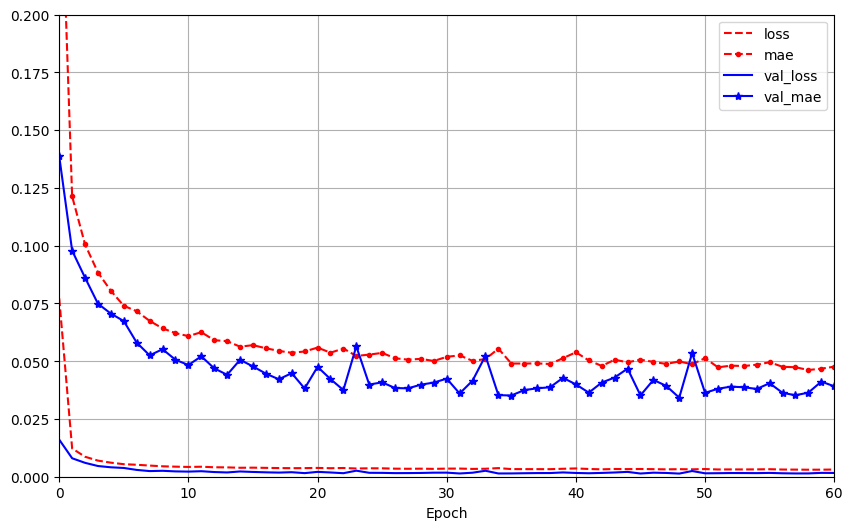

In [33]:
pd.DataFrame(historymulti_var.history).plot(figsize = (10, 6), xlim = [0,60], ylim = [0,0.2], grid =True, xlabel = 'Epoch', style = ['r--', 'r--.', 'b-', 'b-*'])
plt.show()

## Data pipeline utility functions

In [34]:
def to_windows(series , sequence_length):
    window_ds = tf.data.Dataset.from_tensor_slices(series).window(sequence_length , shift = 1, drop_remainder= True)
    return window_ds.flat_map(lambda window_ds : window_ds.batch(sequence_length))

In [35]:
def seq2seq_ds(series , sequence_length=56 , ahead = 14, target_col = 1 , batch_size = 32, shuffle = False, seed =None):
    ds = to_windows(series.to_numpy().astype(np.float32) , ahead+1)
    ds = to_windows(np.array(list(ds.as_numpy_iterator())) , sequence_length).map(lambda S : (S[:, 0], S[: , 1: , 1]))
    if shuffle:
        ds = ds.shuffle(8*batch_size, seed = seed)
    return ds.batch(batch_size)

In [36]:
seq2seq_train = seq2seq_ds(multivar_train, shuffle = True , seed = 42)
seq2seq_valid = seq2seq_ds(multivar_valid)

## Sequence to Sequence model

In [37]:
seq2seq = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32 , return_sequences= True, input_shape = [None, 5]),
    tf.keras.layers.Dense(14)
])

C:\Users\isthi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
seq2seq.compile(loss = tf.keras.losses.Huber(),
                optimizer = tf.keras.optimizers.Adam(beta_1 = 0.9),
                metrics = ['mae'])

In [39]:
s2s_history = seq2seq.fit(seq2seq_train, validation_data= seq2seq_valid, epochs = 500, 
                          callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mae',
                                                                         patience= 50,
                                                                         restore_best_weights = True)])

Epoch 1/500
     28/Unknown 3s 12ms/step - loss: 0.3072 - mae: 0.6887

c:\Program Files\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2903 - mae: 0.6637 - val_loss: 0.0598 - val_mae: 0.2795
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0488 - mae: 0.2442 - val_loss: 0.0247 - val_mae: 0.1614
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - mae: 0.1550 - val_loss: 0.0172 - val_mae: 0.1316
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0170 - mae: 0.1336 - val_loss: 0.0140 - val_mae: 0.1168
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140 - mae: 0.1193 - val_loss: 0.0119 - val_mae: 0.1056
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0119 - mae: 0.1077 - val_loss: 0.0101 - val_mae: 0.0962
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0102 - mae: 0.0977 - val_loss: 0.0089 - val_mae: 0.0887
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - mae: 0.0903 - val_loss: 0.0079 - val_mae: 0.0828
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0083 -

<Axes: xlabel='Epoch'>

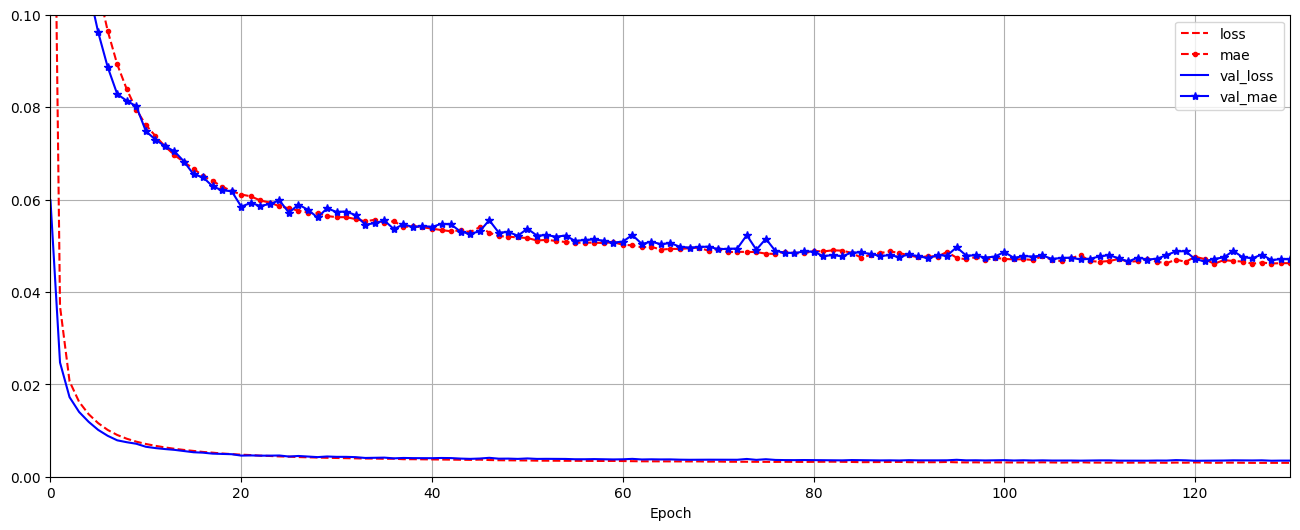

In [40]:
pd.DataFrame(s2s_history.history).plot(figsize = (16, 6), xlim = [0,130], ylim = [0,0.1], grid =True, xlabel = 'Epoch', style = ['r--', 'r--.', 'b-', 'b-*'])

In [41]:
DeepRNNv2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(14)
])